In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
from LinearKalmanNet import LinearKalmanNet
from KalmanNet import KalmanNet
from utils import generate_data, train
from Kalman import KalmanFilter
from LinearSystem import LinearSystem
from NonLinearSystem import NonlinearSystem

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


# Testcase 1: Lineární systém

In [ ]:
# --- Reálný systém ---
F_true = torch.tensor([[0.9]])
H_true = torch.tensor([[1.0]])
Q_true = torch.tensor([[0.1]])
R_true = torch.tensor([[0.1]])
Ex0_true = torch.tensor([[1.0]])  # Očekávaná hodnota počátečního stavu
P0_true = torch.tensor([[2.0]])  # Počáteční kov

sys_true = LinearSystem(Ex0_true,P0_true,F_true, H_true, Q_true, R_true)

F_model = torch.tensor([[0.8]])  # Horší odhad dynamiky
H_model = torch.tensor([[0.8]])
Q_model = torch.tensor([[0.2]])
R_model = torch.tensor([[0.05]])
Ex0_model = torch.tensor([[2.0]])  # Očekávaná hodnota počátečního stavu
P0_model = torch.tensor([[3.0]])  # Počáteční kov

F_model = F_true
H_model = H_true
Q_model = Q_true
R_model = R_true
sys_model = LinearSystem(Ex0_model,P0_model,F_model,H_model,Q_model,R_model)


In [ ]:
x_train, y_train = generate_data(sys_true, num_trajectories=1000, seq_len=100)
x_test, y_test = generate_data(sys_true, num_trajectories=1, seq_len=200) # Jedna delší trajektorie pro test


In [6]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
kalman_filter = KalmanFilter(Ex0_model, P0_model, F_model, H_model, Q_model, R_model)
kf_data = kalman_filter.apply_filter(y_test[0])
x_hat_kf = kf_data['x_filtered']

In [ ]:
knet = LinearKalmanNet(sys_model,128).to(device)
train(knet, train_loader,device,epochs=50, lr=1e-4)

Zahajuji trénování KalmanNetu...
Epocha [5/50], Prům. chyba: 0.064910, Celková norma grad.: 0.0246
Epocha [10/50], Prům. chyba: 0.062801, Celková norma grad.: 0.0493
Epocha [15/50], Prům. chyba: 0.061550, Celková norma grad.: 0.0189
Epocha [20/50], Prům. chyba: 0.060902, Celková norma grad.: 0.0436
Epocha [25/50], Prům. chyba: 0.060755, Celková norma grad.: 0.1681
Epocha [30/50], Prům. chyba: 0.060361, Celková norma grad.: 0.0972
Epocha [35/50], Prům. chyba: 0.060554, Celková norma grad.: 0.0885
Epocha [40/50], Prům. chyba: 0.060398, Celková norma grad.: 0.0758
Epocha [45/50], Prům. chyba: 0.060270, Celková norma grad.: 0.0222
Epocha [50/50], Prům. chyba: 0.060528, Celková norma grad.: 0.0233
Trénování dokončeno.


In [ ]:
knet.eval()
with torch.no_grad():
    y_test_device = y_test.to(device)
    x_hat_knet_test_device = knet(y_test_device)
    x_hat_knet = x_hat_knet_test_device.cpu()

mse_criterion = nn.MSELoss()
mse_knet = mse_criterion(x_hat_knet, x_test)
mse_kf = mse_criterion(x_hat_kf, x_test[0])

print(f"\nVýsledná MSE KalmanNet: {mse_knet.item():.4f}")
print(f"Výsledná MSE klasického KF (nepřesný model): {mse_kf.item():.4f}")


Výsledná MSE KalmanNet: 0.0554
Výsledná MSE klasického KF (nepřesný model): 0.0553


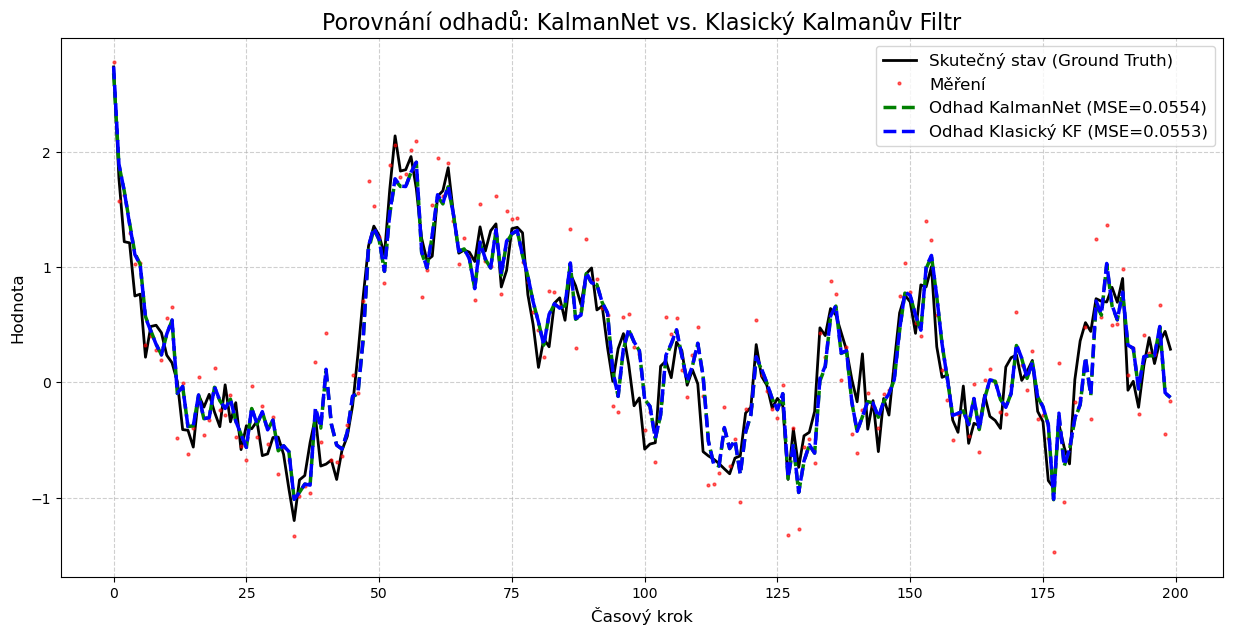

In [ ]:
plt.figure(figsize=(15, 7))
plt.title("Porovnání odhadů: KalmanNet vs. Klasický Kalmanův Filtr", fontsize=16)

x_true_plot = x_test.squeeze().numpy()
y_meas_plot = y_test.squeeze().numpy()
x_hat_knet_plot = x_hat_knet.squeeze().numpy()
x_hat_kf_plot = x_hat_kf.squeeze().numpy()

plt.plot(x_true_plot, 'k-', linewidth=2, label="Skutečný stav (Ground Truth)")
plt.plot(y_meas_plot, 'r.', markersize=4, alpha=0.6, label="Měření")
plt.plot(x_hat_knet_plot, 'g--', linewidth=2.5, label=f"Odhad KalmanNet (MSE={mse_knet.item():.4f})")
plt.plot(x_hat_kf_plot, 'b--', linewidth=2.5, label=f"Odhad Klasický KF (MSE={mse_kf.item():.4f})")

plt.xlabel("Časový krok", fontsize=12)
plt.ylabel("Hodnota", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.show()

# Testcase 2: Nelineární systém

In [ ]:
h_true_nonlinear = lambda x: 0.5 * x
f_true_nonlinear = lambda x: 0.9 * x - 0.05 * x**3 

Q_true = torch.tensor([[0.1]])
R_true = torch.tensor([[0.1]])

Ex0_true = torch.tensor([[1.0]])
P0_true = torch.tensor([[0.5]])

sys_true = NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_true, P0_true)


F_model = torch.tensor([[0.9]])
H_model = torch.tensor([[1.0]]) 

Q_model = torch.tensor([[0.0]])
R_model = torch.tensor([[0.0]])
Ex0_model = torch.tensor([[0.0]])
P0_model = torch.tensor([[0.0]])

sys_model_for_knet = sys_true

In [12]:
x_train, y_train = generate_data(sys_true, num_trajectories=1000, seq_len=100)
x_test, y_test = generate_data(sys_true, num_trajectories=1, seq_len=200)

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [13]:
knet_nelinearni = KalmanNet(sys_model_for_knet).to(device)
train(knet_nelinearni, train_loader, device, epochs=50, lr=1e-4)

Zahajuji trénování KalmanNetu...
Epocha [5/50], Prům. chyba: 0.141397, Celková norma grad.: 0.0349
Epocha [10/50], Prům. chyba: 0.138746, Celková norma grad.: 0.0211
Epocha [15/50], Prům. chyba: 0.136644, Celková norma grad.: 0.0760
Epocha [20/50], Prům. chyba: 0.135225, Celková norma grad.: 0.0210
Epocha [25/50], Prům. chyba: 0.134299, Celková norma grad.: 0.0411
Epocha [30/50], Prům. chyba: 0.133582, Celková norma grad.: 0.0558
Epocha [35/50], Prům. chyba: 0.133429, Celková norma grad.: 0.0582
Epocha [40/50], Prům. chyba: 0.133387, Celková norma grad.: 0.0368
Epocha [45/50], Prům. chyba: 0.133178, Celková norma grad.: 0.0288
Epocha [50/50], Prům. chyba: 0.133047, Celková norma grad.: 0.0323
Trénování dokončeno.



Výsledná MSE KalmanNet na nelineárním systému: 0.1091


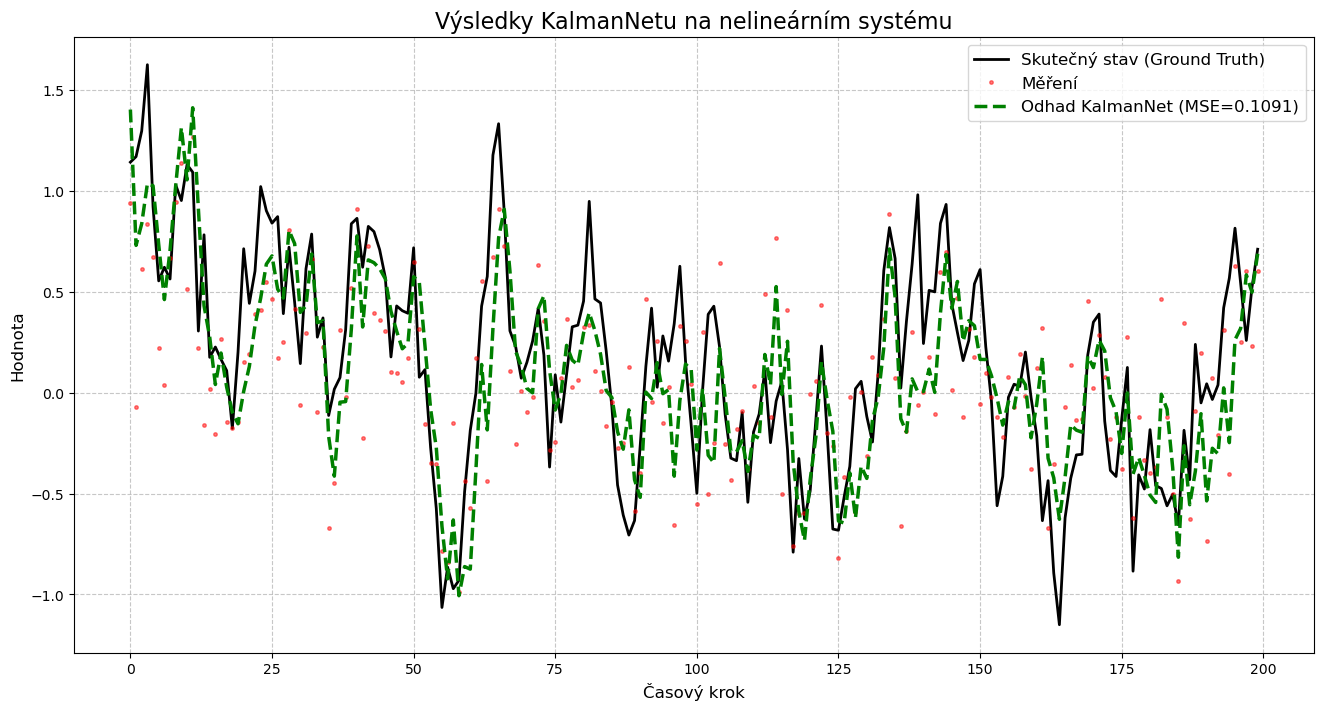

In [ ]:
knet = knet_nelinearni
knet.eval()

with torch.no_grad():
    y_test_device = y_test.to(device)
    x_hat_knet_device = knet(y_test_device)
    x_hat_knet = x_hat_knet_device.cpu()

mse_criterion = nn.MSELoss()
mse_knet = mse_criterion(x_hat_knet, x_test)

print(f"\nVýsledná MSE KalmanNet na nelineárním systému: {mse_knet.item():.4f}")

plt.figure(figsize=(16, 8))
plt.title("Výsledky KalmanNetu na nelineárním systému", fontsize=16)

x_true_plot = x_test.squeeze().numpy()
y_meas_plot = y_test.squeeze().numpy()
x_hat_knet_plot = x_hat_knet.squeeze().numpy()

plt.plot(x_true_plot, 'k-', linewidth=2, label="Skutečný stav (Ground Truth)")
plt.plot(y_meas_plot, 'r.', markersize=5, alpha=0.5, label="Měření")
plt.plot(x_hat_knet_plot, 'g--', linewidth=2.5, label=f"Odhad KalmanNet (MSE={mse_knet.item():.4f})")

plt.xlabel("Časový krok", fontsize=12)
plt.ylabel("Hodnota", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()

# Testování hyperparametrů batch_size

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np 

batch_sizes_to_test = [16, 32, 64, 128, 256] 
num_runs = 5
epochs = 30
lr = 1e-4

results = []

for run in range(num_runs):
    print(f"\n{'='*20} BĚH EXPERIMENTU č. {run + 1}/{num_runs} {'='*20}")
    
    print("Generuji novou sadu trénovacích a testovacích dat...")
    F_true = torch.tensor([[0.9]])
    H_true = torch.tensor([[1.0]])
    Q_true = torch.tensor([[0.1]])
    R_true = torch.tensor([[0.1]])
    Ex0_true = torch.tensor([[1.0]])
    P0_true = torch.tensor([[2.0]])
    sys_true = LinearSystem(Ex0_true, P0_true, F_true, H_true, Q_true, R_true)
    
    F_model = torch.tensor([[0.8]])
    H_model = torch.tensor([[0.8]])
    sys_model = LinearSystem(None, None, F_model, H_model, None, None)

    x_train, y_train = generate_data(sys_true, num_trajectories=1000, seq_len=100)
    x_test, y_test = generate_data(sys_true, num_trajectories=100, seq_len=200)
    
    train_dataset = TensorDataset(x_train, y_train)

    for bs in batch_sizes_to_test:
        print(f"\n--- Testuji Batch Size = {bs} ---")
        
        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        knet = LinearKalmanNet(sys_model, hidden_dim=64).to(device)
        train(knet, train_loader, device, epochs=epochs, lr=lr)
        
        knet.eval()
        with torch.no_grad():
            y_test_device = y_test.to(device)
            x_hat_knet_device = knet(y_test_device)
            x_hat_knet = x_hat_knet_device.cpu()
        
        mse = nn.MSELoss()(x_hat_knet, x_test).item()
        
        if np.isfinite(mse):
            print(f"Výsledná MSE pro Batch Size {bs}: {mse:.6f}")
            results.append({'run': run + 1, 'batch_size': bs, 'mse': mse})
        else:
            print(f"ERROR: Trénování pro Batch Size {bs} selhalo. Výsledná MSE je {mse}.")
            results.append({'run': run + 1, 'batch_size': bs, 'mse': np.nan})



==================== BĚH EXPERIMENTU č. 1/5 ====================
Generuji novou sadu trénovacích a testovacích dat...

--- Testuji Batch Size = 16 ---
Zahajuji trénování KalmanNetu...
Epocha [10/30], Prům. chyba: 2089260363511724244992.000000, Prům. norma grad.: inf
Epocha [20/30], Prům. chyba: 2080558304633298354176.000000, Prům. norma grad.: inf
Epocha [30/30], Prům. chyba: 2089841411915210555392.000000, Prům. norma grad.: inf
Trénování dokončeno.
ERROR: Trénování pro Batch Size 16 selhalo. Výsledná MSE je inf.

--- Testuji Batch Size = 32 ---
Zahajuji trénování KalmanNetu...
Epocha [10/30], Prům. chyba: 5815066271073712472064.000000, Prům. norma grad.: inf
Epocha [20/30], Prům. chyba: 0.066716, Prům. norma grad.: 0.0306
Epocha [30/30], Prům. chyba: 0.064354, Prům. norma grad.: 0.0365
Trénování dokončeno.
Výsledná MSE pro Batch Size 32: 0.062260

--- Testuji Batch Size = 64 ---
Zahajuji trénování KalmanNetu...
Epocha [10/30], Prům. chyba: 0.069675, Prům. norma grad.: 0.0469
Epocha [


--- Finální výsledky experimentu ---
Statistiky z úspěšných běhů:
                mean       std       min       max  count
batch_size                                               
16          0.061985  0.000405  0.061534  0.062485      4
32          0.062601  0.000532  0.062020  0.063413      5
64          0.063780  0.000756  0.062614  0.064676      5
128         0.064572       NaN  0.064572  0.064572      1
256         0.067041  0.001647  0.065394  0.069546      5


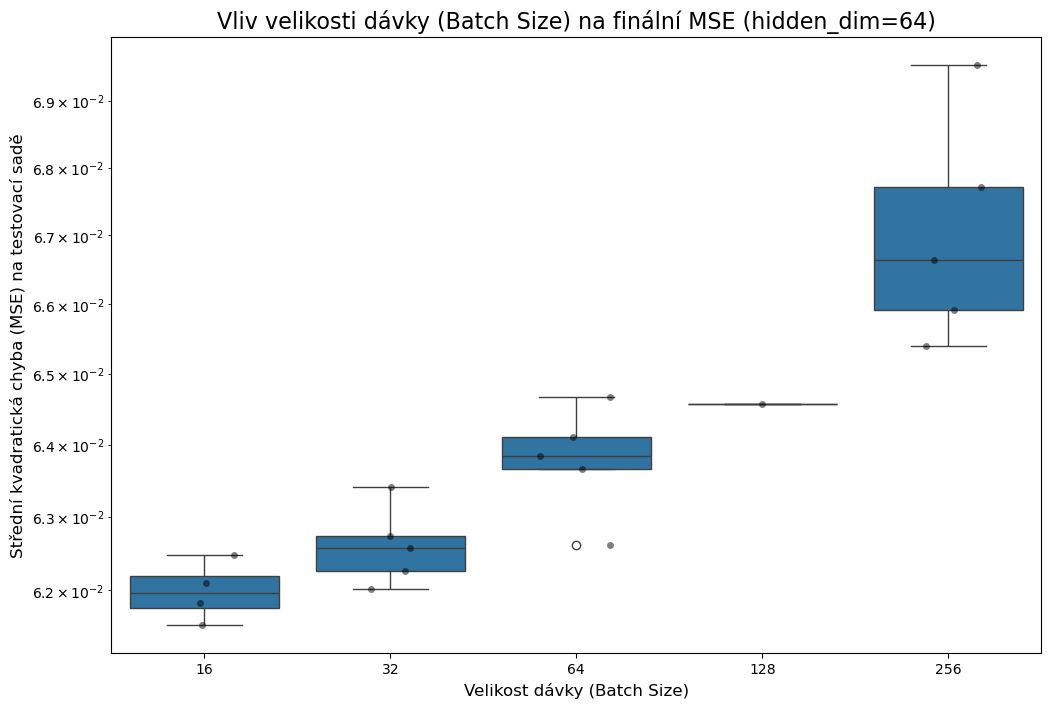

In [ ]:
print("\n--- Finální výsledky experimentu ---")

results_df = pd.DataFrame(results)

valid_results_df = results_df.dropna()

if valid_results_df.empty:
    print("Všechny běhy selhaly. Nelze vykreslit graf ani zobrazit statistiky.")
else:
    print("Statistiky z úspěšných běhů:")
    avg_results = valid_results_df.groupby('batch_size')['mse'].agg(['mean', 'std', 'min', 'max', 'count'])
    print(avg_results)

    plt.figure(figsize=(12, 8))
    sns.boxplot(x='batch_size', y='mse', data=valid_results_df)
    sns.stripplot(x='batch_size', y='mse', data=valid_results_df, color='black', alpha=0.5, jitter=0.2)

    plt.title('Vliv velikosti dávky (Batch Size) na finální MSE (hidden_dim=64)', fontsize=16)
    plt.xlabel('Velikost dávky (Batch Size)', fontsize=12)
    plt.ylabel('Střední kvadratická chyba (MSE) na testovací sadě', fontsize=12)
    plt.yscale('log')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()